(NLP From Scratch: Generating Names with a Character-Level RNN)[https://pytorch.org/tutorials/intermediate/char_rnn_generation_tutorial.html]


Download the data from [here](https://download.pytorch.org/tutorial/data.zip) and extract it to the current directory.

In [42]:
from io import open
import glob
import os
import unicodedata
import string

In [43]:
all_letters = string.ascii_letters + " .,;'-"
n_letters = len(all_letters) + 1

In [44]:
def findFiles(path):return glob.glob(path)

In [45]:
def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
        and c in all_letters
    )

In [46]:
def readLines(filename):
    with open(filename, encoding = 'utf-8') as some_file:
        return [unicodeToAscii(line.strip()) for line in some_file]

In [47]:
category_lines = {}
all_categories = []

for filename in findFiles('data/names/*.txt'):
    category = os.path.splitext(os.path.basename(filename))[0]
    all_categories.append(category)
    category_lines[category] = readLines(filename)

In [48]:
print(category_lines['Polish'][:5])

['Adamczak', 'Adamczyk', 'Andrysiak', 'Auttenberg', 'Bartosz']


In [49]:
n_categories = len(all_categories)

In [50]:
print("# categories", n_categories, all_categories)

# categories 18 ['Czech', 'German', 'Arabic', 'Japanese', 'Chinese', 'Vietnamese', 'Russian', 'French', 'Irish', 'English', 'Spanish', 'Greek', 'Italian', 'Portuguese', 'Scottish', 'Dutch', 'Korean', 'Polish']


In [51]:
print(unicodeToAscii("O'Néàl"))

O'Neal


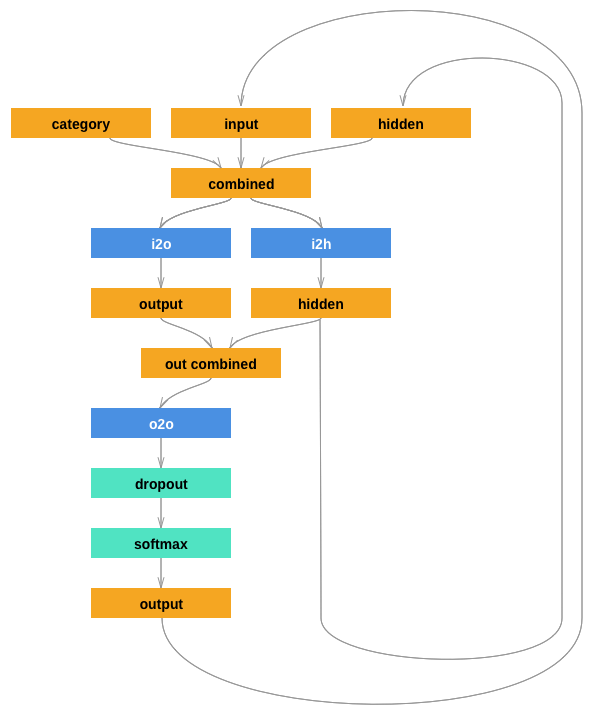

In [52]:
import torch
import torch.nn as nn

class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNN, self).__init__()
        self.hidden_size = hidden_size

        self.i2h = nn.Linear(n_categories + input_size + hidden_size, hidden_size)
        self.i2o = nn.Linear(n_categories + input_size + hidden_size, output_size)
        self.o2o = nn.Linear(hidden_size + output_size, output_size)
        self.dropout = nn.Dropout(0.1)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, category, input, hidden):
        input_combined = torch.cat((category, input, hidden), 1)
        hidden = self.i2h(input_combined)
        output = self.i2o(input_combined)
        out_combined = torch.cat((hidden, output), 1)
        output = self.o2o(out_combined)
        output = self.dropout(output)
        output = self.softmax(output)
        return output,hidden
    
    def initHidden(self):
        return torch.zeros(1, self.hidden_size)
    




In [53]:
import random

def randomChoice(l):
    return l[random.randint(0, len(l) - 1)]

def randomTrainingPair():
    category = randomChoice(all_categories)
    line = randomChoice(category_lines[category])
    return category, line

In [54]:
def categoryTensor(category):
    li = all_categories.index(category)
    tensor = torch.zeros(1, n_categories)
    tensor[0][li] = 1
    return tensor

def inputTensor(line):
    tensor = torch.zeros(len(line), 1, n_letters)
    for li in range(len(line)):
        letter = line[li]
        tensor[li][0][all_letters.find(letter)] = 1

    return tensor

In [55]:
def targetTensor(line):
    letter_indexes = [all_letters.find(line[li]) for li in range(1, len(line))]
    letter_indexes.append(n_letters - 1) # EOS
    return torch.LongTensor(letter_indexes)

In [56]:
def randomTrainingExample():
    category, line = randomTrainingPair()
    category_tensor = categoryTensor(category)
    input_line_tensor = inputTensor(line)
    target_line_tensor = targetTensor(line)
    return category_tensor, input_line_tensor, target_line_tensor

In [57]:
criterion = nn.NLLLoss()

learning_rate = 0.0005

In [58]:
def train(category_tensor, input_line_tensor, target_line_tensor):
    target_line_tensor.unsqueeze_(-1)
    hidden = rnn.initHidden()

    rnn.zero_grad()

    loss = torch.Tensor([0])

    for i in range(input_line_tensor.size()[0]):
        output, hidden = rnn(category_tensor, input_line_tensor[i], hidden)
        l = criterion(output, target_line_tensor[i])
        loss += l

    loss.backward()

    for p in rnn.parameters():
        p.data.add_(p.grad.data,  alpha = -learning_rate)

    return output, loss.item() / input_line_tensor.size(0)



In [59]:
import time
import math
def timeSince(since):
    now = time.time()
    s = now - since
    m = math.floor(s/60)
    s -= m * 60
    return '%dm %ds' % (m, s)

In [61]:
rnn = RNN(n_letters, 128, n_letters)

n_iters = 100000
print_every = 5000
plot_every = 500
all_losses = []
total_loss = 0

start=  time.time()


for iter in range(1, n_iters+1):
    output, loss = train(*randomTrainingExample())
    total_loss += loss

    if iter % print_every == 0:
        print('%s (%d %d%%) %.4f' % (timeSince(start), iter, iter/n_iters * 100, loss))

    if iter % plot_every == 0:
        all_losses.append(total_loss/ plot_every)
        total_loss = 0

0m 4s (5000 5%) 3.2034
0m 9s (10000 10%) 2.7153
0m 13s (15000 15%) 2.5768
0m 18s (20000 20%) 2.3357
0m 23s (25000 25%) 2.1157
0m 28s (30000 30%) 2.5749
0m 33s (35000 35%) 1.7914
0m 38s (40000 40%) 2.5505
0m 42s (45000 45%) 2.5490
0m 47s (50000 50%) 2.5680
0m 52s (55000 55%) 2.3098
0m 56s (60000 60%) 2.6297
1m 1s (65000 65%) 1.3051
1m 6s (70000 70%) 2.2404
1m 10s (75000 75%) 2.7944
1m 15s (80000 80%) 2.9631
1m 20s (85000 85%) 1.1254
1m 25s (90000 90%) 2.8148
1m 30s (95000 95%) 2.3297
1m 34s (100000 100%) 3.5021


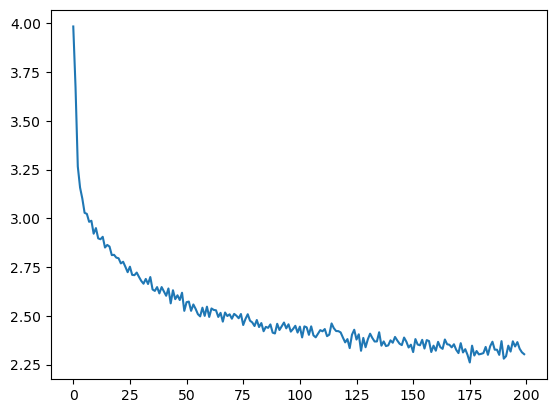

In [62]:
import matplotlib.pyplot as plt

plt.figure()
plt.plot(all_losses)

In [63]:
max_length = 20

# Sample from a category and starting letter
def sample(category, start_letter='A'):
    with torch.no_grad():  # no need to track history in sampling
        category_tensor = categoryTensor(category)
        input = inputTensor(start_letter)
        hidden = rnn.initHidden()

        output_name = start_letter

        for i in range(max_length):
            output, hidden = rnn(category_tensor, input[0], hidden)
            topv, topi = output.topk(1)
            topi = topi[0][0]
            if topi == n_letters - 1:
                break
            else:
                letter = all_letters[topi]
                output_name += letter
            input = inputTensor(letter)

        return output_name

# Get multiple samples from one category and multiple starting letters
def samples(category, start_letters='ABC'):
    for start_letter in start_letters:
        print(sample(category, start_letter))

samples('Russian', 'RUS')

samples('German', 'GER')

samples('Spanish', 'SPA')

samples('Chinese', 'CHI')

Roverov
Uantenov
Shitonov
Gertert
Eres
Rourer
Saras
Para
Arana
Chan
Ha
Iun
